In [1]:
import sys
sys.path.append('/home/monte.flora/python_packages/WoF_post')
from wofs.verification.lsrs.get_storm_reports import StormReports
from glob import glob
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from os.path import join

In [2]:
import cartopy.crs as ccrs
from cartopy.feature import NaturalEarthFeature
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
from cartopy.feature import ShapelyFeature

In [3]:
# Plot all reports in the WoFS domain and visually compare to SPC. 
duration = (30-17)*60 
date = '20210504' #'20210504', '20180502', '20180514'
initial_time = f'{date}1700'

#path='/work/mflora/LSRS/lsr_201703010000_202106090000.csv'
path='/work/mflora/LSRS/'
reporter = StormReports(initial_time, forecast_length=duration, err_window=15, 
                        path=path)

For 2021 dataset, loading local storm reports...


In [4]:
print(reporter.start_date, reporter.end_date)

2021-05-04 16:45:00 2021-05-05 06:15:00


In [5]:
# Return a dict with the hazard type as keys and the lat/lon combos 
geo_points = reporter()

/home/monte.flora/python_packages/WoF_post/wofs/verification/lsrs/get_storm_reports.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df.MAG[inds] = 55.0


In [6]:
from glob import glob
ds = xr.load_dataset(glob(f'/work/mflora/SummaryFiles/{date}/0000/wofs_ENS_00*')[0], decode_times=False)

lats = ds['xlat']
lons = ds['xlon']

shape = (len(lons), len(lats))

central_longitude = ds.attrs['STAND_LON']
central_latitude = ds.attrs['CEN_LAT']

standard_parallels = (ds.attrs['TRUELAT1'], ds.attrs['TRUELAT2'])
projection=ccrs.LambertConformal(central_longitude=central_longitude,
                                 central_latitude=central_latitude,
                                 standard_parallels=standard_parallels)
crs = ccrs.PlateCarree()
data_path = '/home/monte.flora/python_packages/WoF_post/wofs/data/'
states = NaturalEarthFeature(category="cultural", scale="10m",
                             facecolor="none",
                             name="admin_1_states_provinces")

county_file = join(data_path,'COUNTIES', 'countyl010g')
reader = shpreader.Reader(county_file)
shape_feature = ShapelyFeature(reader.geometries(),
                               crs, facecolor='none', linewidth=0.2, edgecolor='black', )

def add_map_stuff(ax, states, shape_feature):
    ax.add_feature(states, linewidth=.1, facecolor='none', edgecolor="black")
    ax.add_feature(cfeature.LAKES, linewidth=.1, facecolor='none', edgecolor="black")
    ax.add_feature(cfeature.COASTLINE, linewidth=.1, facecolor='none', edgecolor="black")        
    ax.add_feature(shape_feature)
    
    
def set_extent(ax, projection, crs, lats, lons,):
    """ Set the Map extent based the WoFS domain """
    # Set the extent. 
    xs, ys, _ = projection.transform_points(
            crs,
            np.array([lons.min(), lons.max()]),
            np.array([lats.min(), lats.max()])).T
    _xlimits = xs.tolist()
    _ylimits = ys.tolist()

    # The limit is max(lower bound), min(upper bound). This will create 
    # a square plot and make sure there is no white spaces between the map
    # the bounding box created by matplotlib. This also allows us to set the
    # WoFS domain boundaries in cases where we aren't plotting WoFS data 
    # (e.g., storm reports, warning polygons, etc.) 
    lims = (max([_xlimits[0]]+[_ylimits[0]]),min([_xlimits[-1]]+[_ylimits[-1]]))
        
    ax.set_xlim(lims)
    ax.set_ylim(lims) 
    
    return ax

In [7]:
print(lats.min(), lats.max())

<xarray.DataArray 'xlat' ()>
array(29.57950974) <xarray.DataArray 'xlat' ()>
array(37.8763237)


In [8]:
print(lons.min(), lons.max())

<xarray.DataArray 'xlon' ()>
array(-94.12966919) <xarray.DataArray 'xlon' ()>
array(-83.65368652)


### Check 1. Translation from Lat/Long to Y,X is correct. 

In [9]:
ds = xr.load_dataset(glob(f'/work/mflora/SummaryFiles/{date}/0000/wofs_ENS_00*')[0], decode_times=False)
# Returns a dict with the hazard type (['hail','wind','tornado']_['severe', 'sig_severe']) 
# as keys and x,y combos as items. 
points = reporter.get_points(ds)

/home/monte.flora/python_packages/WoF_post/wofs/verification/lsrs/get_storm_reports.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df.MAG[inds] = 55.0


In [10]:
colors = {'hail' : 'green',
          'wind' : 'blue', 
          'tornado' : 'red'
         }
markers = {'hail' : 'o', 
         'wind' : 's', 
         'tornado' : 'v'}

#### Storm reports in Lat/Long Space

tornado (21, 2)
hail (12, 2)
wind (653, 2)


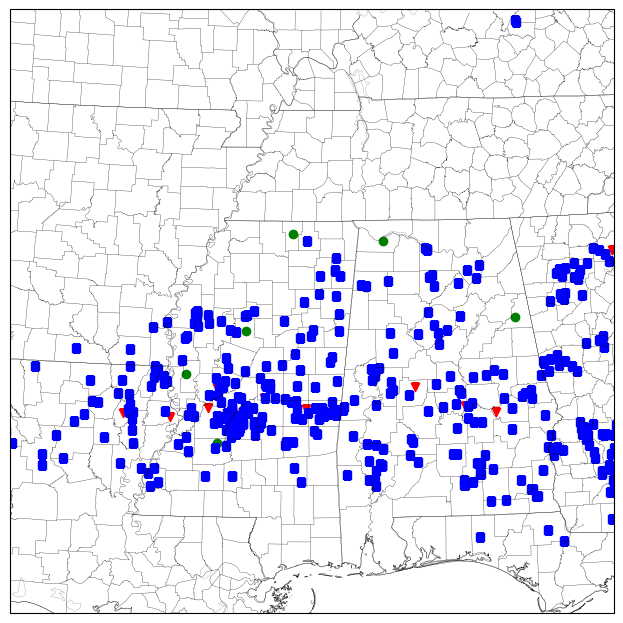

In [11]:
%matplotlib inline
f, ax = plt.subplots(dpi=100, figsize=(8,8), subplot_kw={'projection': projection})

add_map_stuff(ax, states, shape_feature)
for hazard in geo_points.keys():
    # TODO: convert to array inside StormReporter
    data = np.array(geo_points[hazard])
    print(hazard, data.shape)
    name = hazard.split('_')[0]
    if len(data) > 0:
        if 'sig' in hazard:
            ax.scatter(data[:,1], data[:,0], color='k', marker=markers[name], transform=crs)
        else:
            ax.scatter(data[:,1], data[:,0], color=colors[name], marker=markers[name], transform=crs)
            
ax = set_extent(ax, projection , crs, lats, lons,)
#ax.grid(alpha=0.8, ls='dashed')

tornado_severe (18, 2)
hail_severe (6, 2)
wind_severe (386, 2)
tornado_sig_severe (0,)
hail_sig_severe (0,)
wind_sig_severe (8, 2)


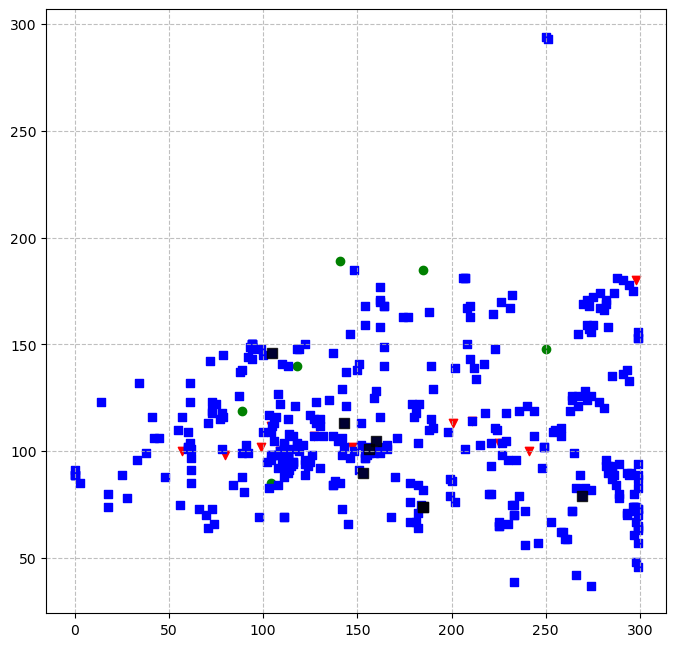

In [12]:
%matplotlib inline
f, ax = plt.subplots(dpi=100, figsize=(8,8),)
for hazard in points.keys():
    # TODO: convert to array inside StormReporter
    data = np.array(points[hazard])
    print(hazard, data.shape)
    name = hazard.split('_')[0]
    if len(data) > 0:
        if 'sig' in hazard:
            ax.scatter(data[:, 1], data[:, 0], color='k', marker=markers[name], s=50, alpha=0.8)
        else:
            ax.scatter(data[:, 1], data[:, 0], color=colors[name], marker=markers[name],)
ax.grid(alpha=0.8, ls='dashed')

### Check 2. Translation from Y,X to Gridded is correct. 

In [13]:
grid_ds = reporter.to_grid(ds)

/home/monte.flora/python_packages/WoF_post/wofs/verification/lsrs/get_storm_reports.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df.MAG[inds] = 55.0


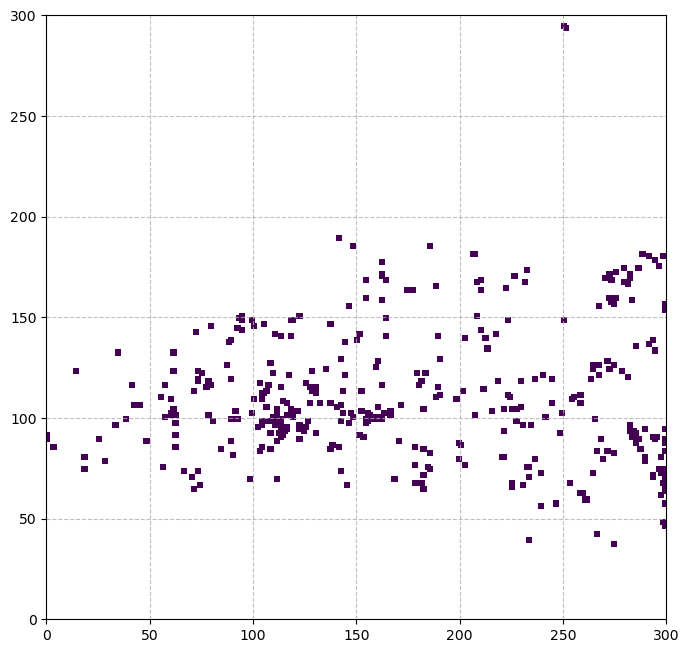

In [14]:
%matplotlib inline
f, ax = plt.subplots(dpi=100, figsize=(8,8),)
for v in grid_ds.data_vars:
    binary = np.where(grid_ds[v] > 0, 1, 0)
    data = np.ma.masked_where(binary==0, binary)
    ax.pcolormesh(data)
ax.grid(alpha=0.8, ls='dashed')